In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

I  start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `obp` is just a replicated array of coordinates, and `objp` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  







In [2]:
#Object Points
obp=[] 
#ImagePoints
imp=[]

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

#Load the images for Camera Calibration
image = glob.glob('camera_cal/calibration*.jpg')

As told in classroom there are 9 corners in a row and 6 corners in a column for the chessboard pattern. I have used glob to iterate over all the camera_cal images to extract the object and image points . I am using `cv2.findChessboardCorners` to find the corners and then `cv2.drawChessboardCorners` to draw the lines. The result look as follows after using both the functions

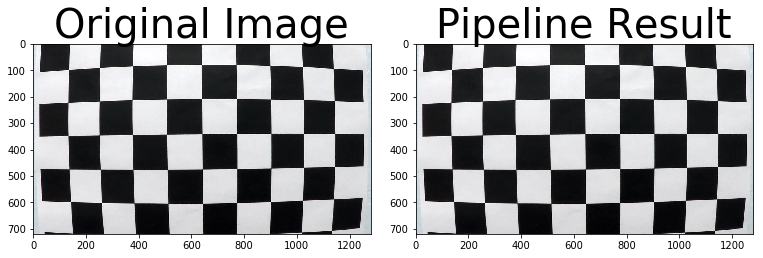

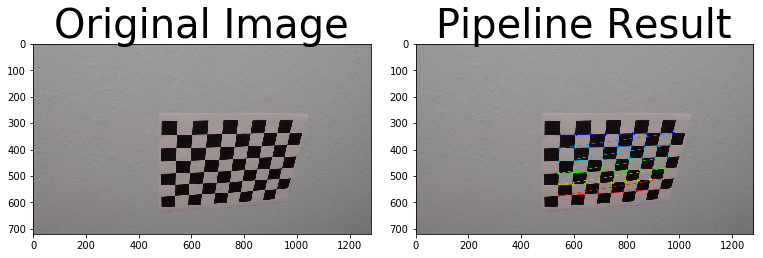

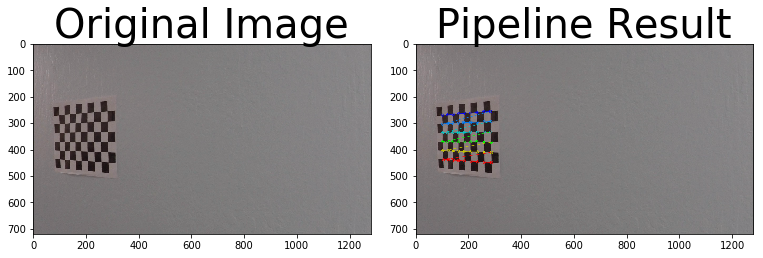

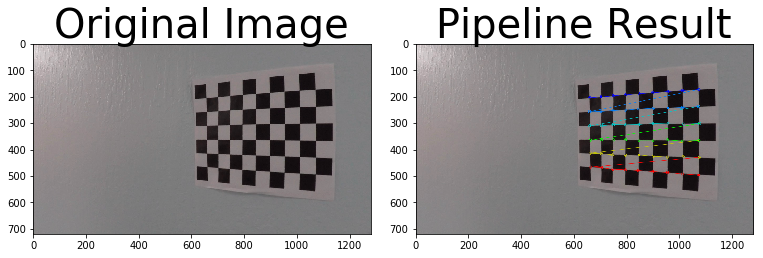

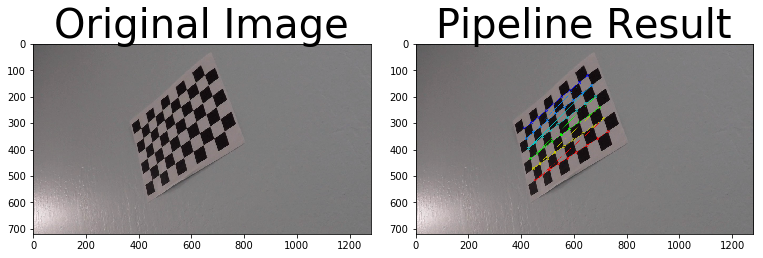

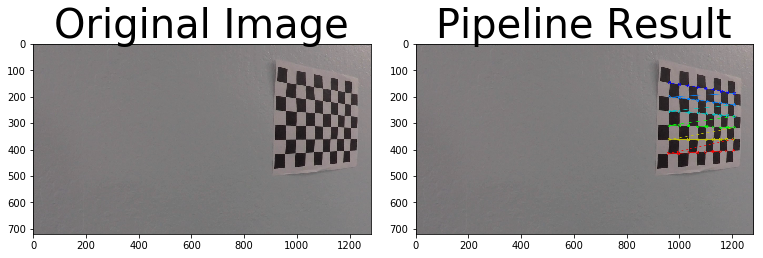

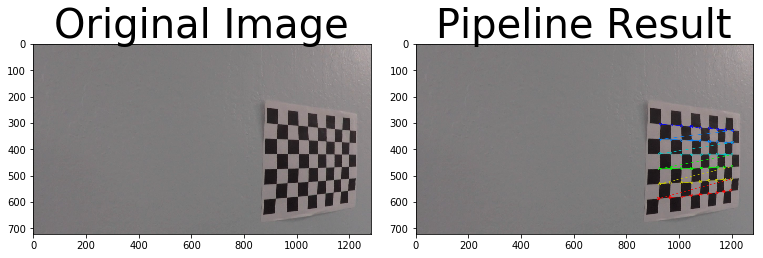

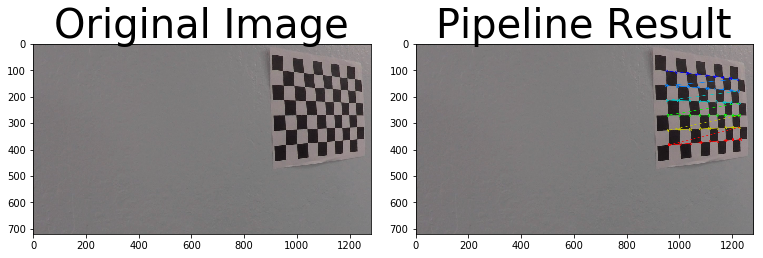

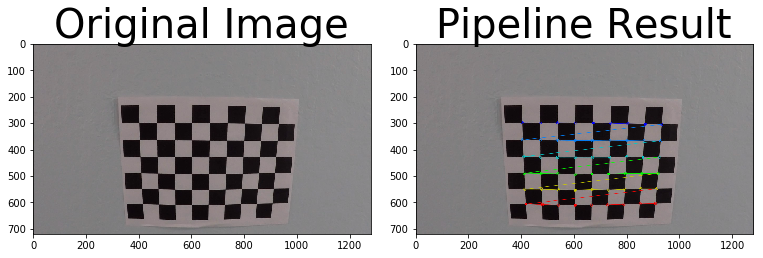

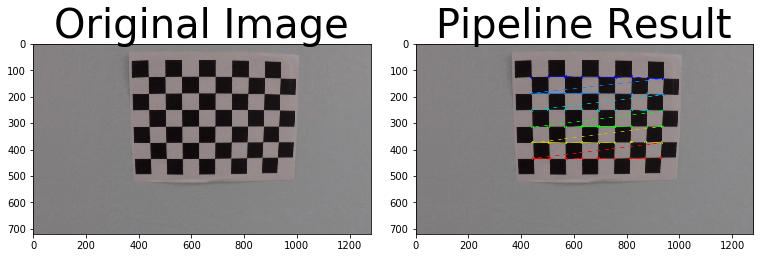

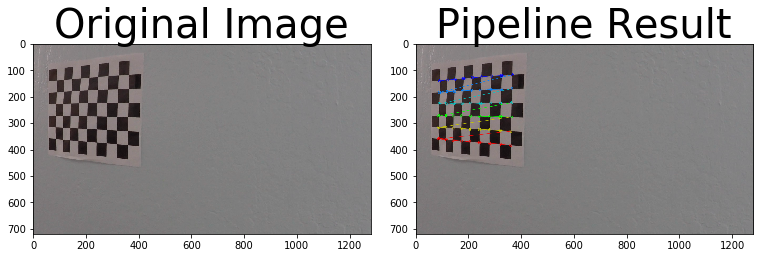

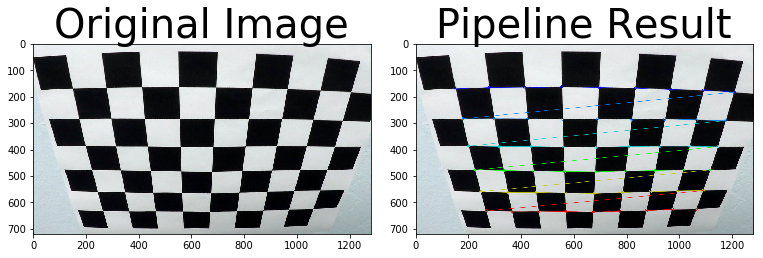

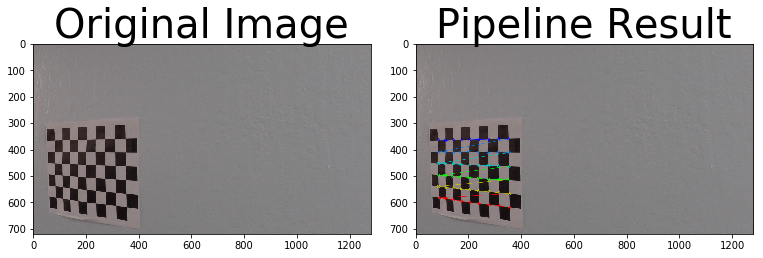

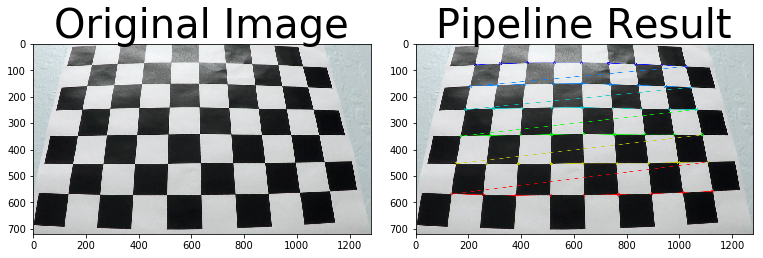

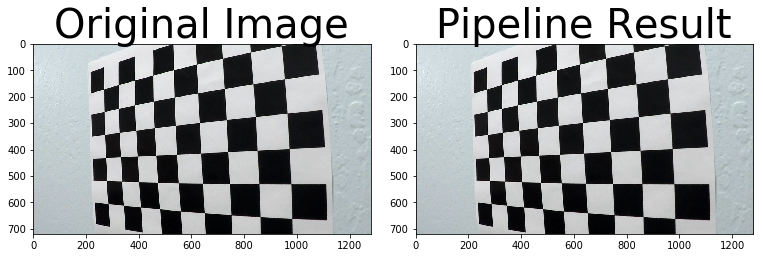

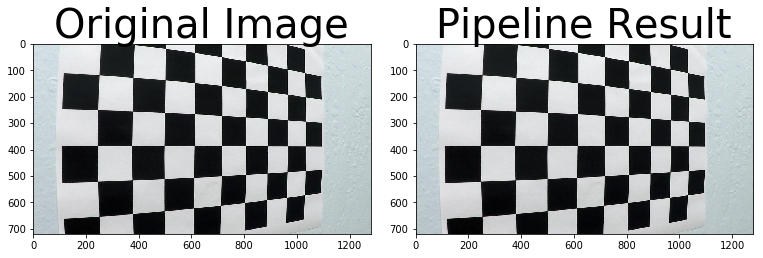

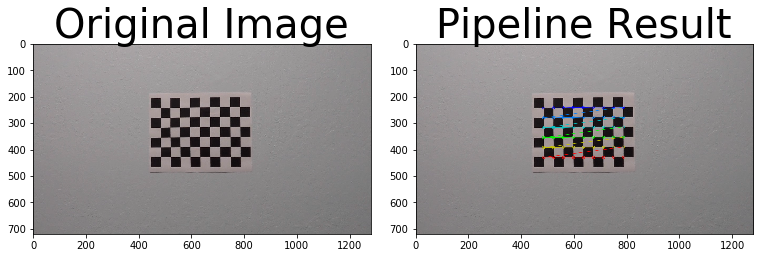

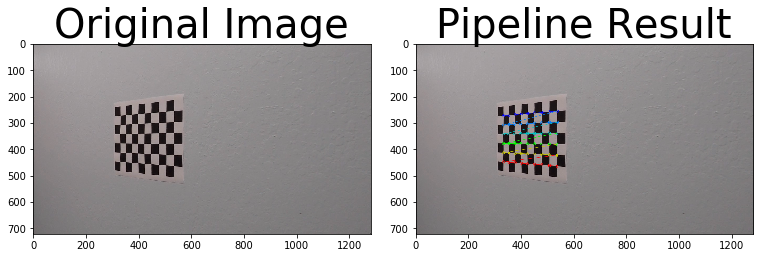

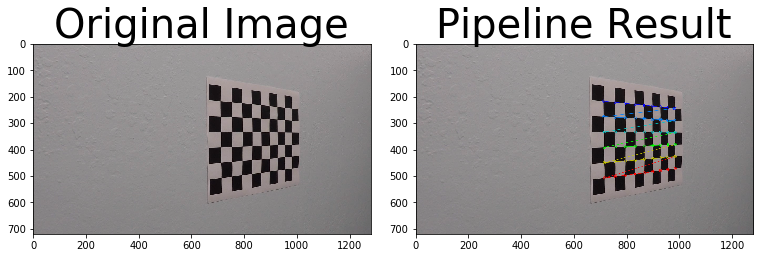

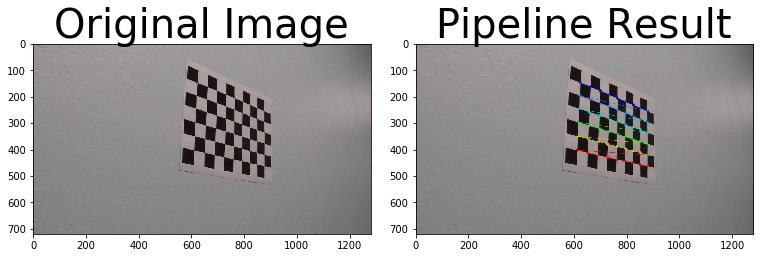

In [3]:
for idx,file in enumerate(image):
    
    img=cv2.imread(file)
    orgimg=np.copy(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret==True:
        obp.append(objp)
        imp.append(corners)
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
    
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()

    ax1.imshow(orgimg)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(img)
    ax2.set_title('Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  

In [4]:
img = cv2.imread('camera_cal/calibration1.jpg')
imgSize=(img.shape[0],img.shape[1])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obp, imp,imgSize,None,None)


Once I have the calibration matrix and the distortion coefficients I dump it in `calibrationData.pickle` file so that i may not have to calculate these values again

In [5]:
camData = {'matrix':mtx,'distortion':dist}
with open('calibrationData.pickle', 'wb') as calData:
    pickle.dump(camData, calData, protocol=pickle.HIGHEST_PROTOCOL)
    

## Undistortion

Before undistortion of the images I loaded the required camera callibaration matrix and the distortion coefficients from the `calibrationData.pickle`

In [6]:
dist_pickle = pickle.load( open( "calibrationData.pickle", "rb" ) )
mtx = dist_pickle["matrix"]
dist = dist_pickle["distortion"]

I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

In [7]:
def undistort(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

Here i have shown an example of how the above function works for one of the distorted images in the `camera_cal`. The result contains the distorted image and the undistorted images.

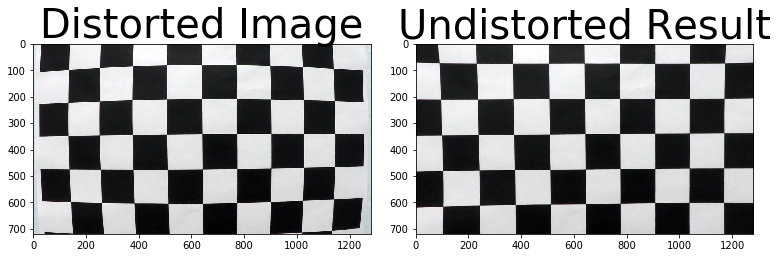

In [8]:
img = cv2.imread('camera_cal/calibration1.jpg')
dst = undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Distorted Image', fontsize=40)

ax2.imshow(dst)
ax2.set_title('Undistorted Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.

To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:

In [9]:
image = glob.glob('test_images/test*.jpg')

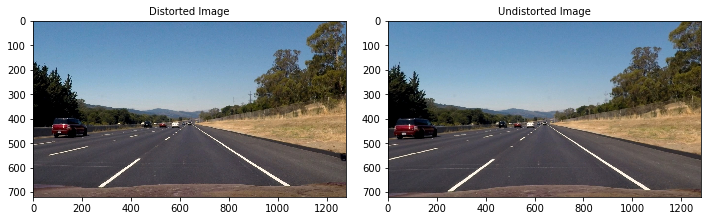

In [10]:
undistortedImages=[]
for idx,frame in enumerate(image):
    img=cv2.imread(frame)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undistortedImages.append(img)
    dst=undistort(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Distorted Image', fontsize=10)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=10)

## Creating a thresholded binary image


#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

I used a combination of color and gradient thresholds to generate a binary image. I will be explaining that by covering each code block as follow:

I have used three different color space in this project to perform color and gradient threshold i.e `cv2.COLOR_RGB2HLS` , `cv2.COLOR_RGB2GRAY` and `cv2.COLOR_RGB2LAB`

In [11]:
def rgb_hls(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    return hls

def rgb_gray(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray

def rgb_lab(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    return lab

### Color Threshold

My objective was to detect white line and the yellow line for which i tried i tried different combinations of color channel in different color space . To make the writeup concise i will explain the combination that i have used in myh project. 
In order to detect the yellow lane line I tooked the `b_channel` of LAB color space and `red channel` of the RGB color space and for the white lane line i tooked a threshold value of `184` for the channel of the RGB color space . This value was the best possible value after trying multple values in range of 150-250 with the help of which white lane lines were detected.
I have then combined both of this which resulted in a binary image that showed both the yellow and white lane. To demonstrate this please refer the next code block

In [12]:
def colorThreshold(image):
    lab=rgb_lab(image)
    b_channel = lab[:,:,2]
    red_channel = image[:,:,0]
    combibe_b_r_channel = (red_channel > 150) & (b_channel > 150)
    
    
    green_channel = image[:,:,1]
    blue_channel = image[:,:,2]
    
    whiteLine = (red_channel > 184) & (blue_channel > 184) & (green_channel > 184)
    combineThreshold = np.zeros_like(red_channel)
    combineThreshold[combibe_b_r_channel | whiteLine]=1
    return combineThreshold
    

To demonstrate this step, I have shown the color threshold on the test image .
`combine_b_r_channel shows ` shows the yellow lane line on binary image
`whiteLine` shows the white lane line on binary image
`combineThreshold` shows the combonation of both binary image

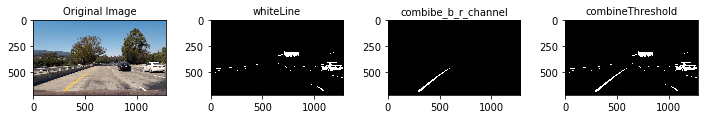

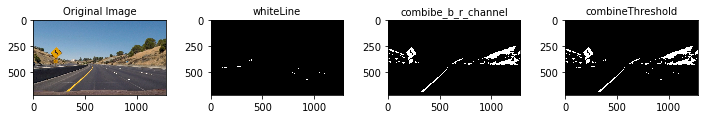

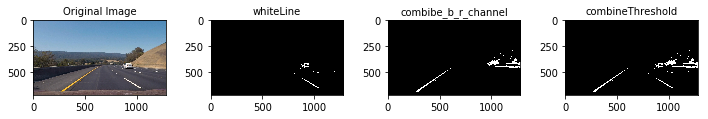

In [13]:
for image in undistortedImages[:3]:
    lab=rgb_lab(image)
    b_channel = lab[:,:,2]
    red_channel = image[:,:,0]
    combibe_b_r_channel = (red_channel > 150) & (b_channel > 150)
    
    
    green_channel = image[:,:,1]
    blue_channel = image[:,:,2]
    
    whiteLine = (red_channel > 184) & (blue_channel > 184) & (green_channel > 184)
    combineThreshold = np.zeros_like(red_channel)
    combineThreshold[combibe_b_r_channel | whiteLine]=1
    
    
    f, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 5))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=10)
    
    ax2.imshow(whiteLine, cmap='gray')
    ax2.set_title('whiteLine', fontsize=10)
    
    ax3.imshow(combibe_b_r_channel, cmap='gray')
    ax3.set_title('combibe_b_r_channel', fontsize=10)
    
    ax4.imshow(combineThreshold, cmap='gray')
    ax4.set_title('combineThreshold', fontsize=10)


### Gradient Threshold

For the gradient thereshold I have done it in two steps:
1) I tooked the sobel gradient along x axis as the lane are vertical 
2) I tooked the direction gradient at an angle of 30 and 90 degree to detect the lane lines

To perform both these things I tooked the method provided in the classroom 


In [14]:
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [15]:
def sobel_x(gray,thresh_min=20, thresh_max=100):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

`get_gradient_threshold` this fucnction  is use to combine both the gradient thresholds and return a gradient binary output

In [16]:
def get_gradient_threshold(image):
    gray = rgb_gray(image)
    height, width = gray.shape
    sx_binary = sobel_x(gray)
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    return combined_condition
    
    

To demonstrate this step, I have shown the gradient threshold on few test image .
`sx_binary ` shows the sobel x gradient
`dr_binary` shows the direction gradient for an angle of 30 and 90 degree
`combined_gradient` shows the combination of both gradient image

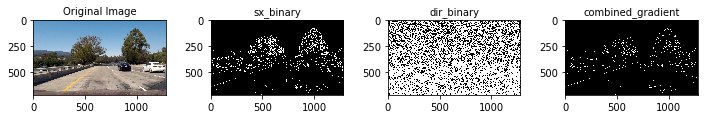

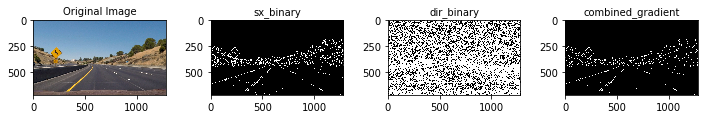

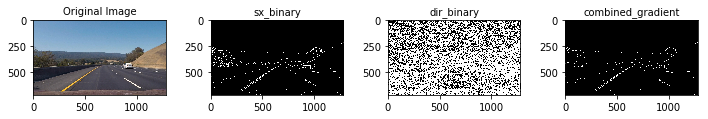

In [17]:
for image in undistortedImages[:3]:
    
    gradientThreshold = get_gradient_threshold(image)
    gray = rgb_gray(image)
    sx_binary = sobel_x(gray)
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    
    f, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 5))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=10)
    
    ax2.imshow(sx_binary, cmap='gray')
    ax2.set_title('sx_binary', fontsize=10)
    
    ax3.imshow(dir_binary, cmap='gray')
    ax3.set_title('dir_binary', fontsize=10)
    
    ax4.imshow(gradientThreshold, cmap='gray')
    ax4.set_title('combined_gradient', fontsize=10)


### Combining Threshold

Finally once I get the binary image of both color threshold and the gradient threshold i combine them to get the final binary image. Here's an example of my output for this step.  (note: this is not actually from one of the test images)

In [18]:
def get_thresholded_image(image):
    colorBinary=colorThreshold(image)
    gradientBinary=get_gradient_threshold(image)
    result=((gradientBinary == 1) | (colorBinary == 1))
    combined_binary = np.zeros_like(colorBinary)
    combined_binary[(gradientBinary == 1) | (colorBinary == 1)] = 1
    return combined_binary
    

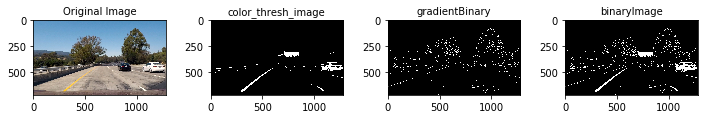

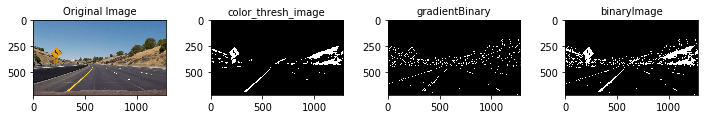

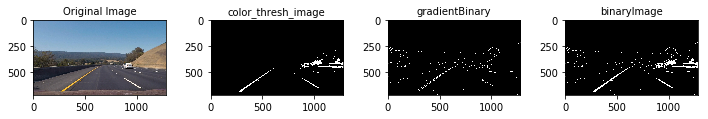

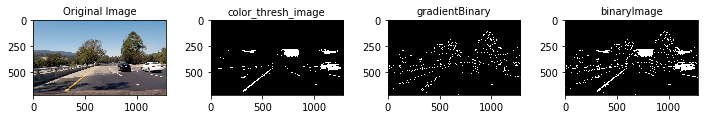

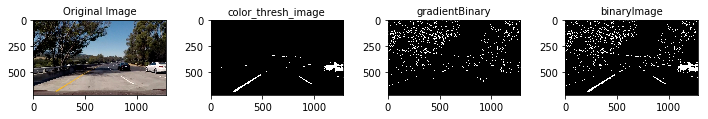

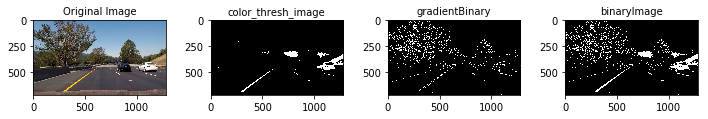

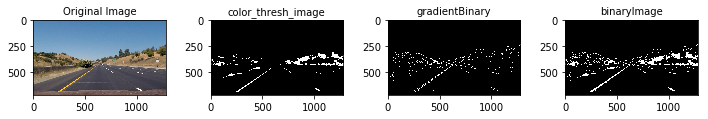

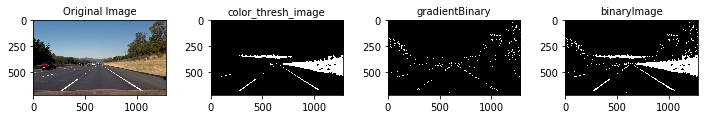

In [19]:
binaryImage = []

for image in undistortedImages:
    colorBinary=colorThreshold(image)
    gradientBinary=get_gradient_threshold(image)
    result=((gradientBinary == 1) | (colorBinary == 1))
    combined_binary = np.zeros_like(colorBinary)
    combined_binary[(gradientBinary == 1) | (colorBinary == 1)] = 1
    binaryImage.append(get_thresholded_image(image))
    
    f, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 5))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=10)
    
    ax2.imshow(colorBinary, cmap='gray')
    ax2.set_title('color_thresh_image', fontsize=10)
    
    ax3.imshow(gradientBinary, cmap='gray')
    ax3.set_title('gradientBinary', fontsize=10)
    
    ax4.imshow(combined_binary, cmap='gray')
    ax4.set_title('binaryImage', fontsize=10)

## PERSPECTIVE TRANSFORM

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.


The code for my perspective transform includes a function called `perspectiveTransform()`. This function takes as inputs a binary image (`img`), I chose the following src and dest value after trying on several other values as it resulted in an wraped image that showed the lanes much or less parallel:


In [20]:
def perspectiveTransform(binaryImage):
    h,w=binaryImage.shape[0],binaryImage.shape[1]
    br = [220,720]
    bl = [1110, 720]
    tr = [570, 470]
    tl = [722, 470]
    
    src=np.float32([
        br,bl,tr,tl
    ])
    
    dest=np.float32([
        [320,720],[920, 720],[320, 1],[920, 1]
    ])
    
    M = cv2.getPerspectiveTransform(src, dest)
    Minv = cv2.getPerspectiveTransform(dest, src)
    warped = cv2.warpPerspective(binaryImage, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped,M,Minv

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

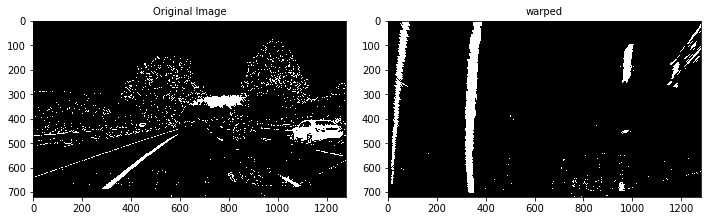

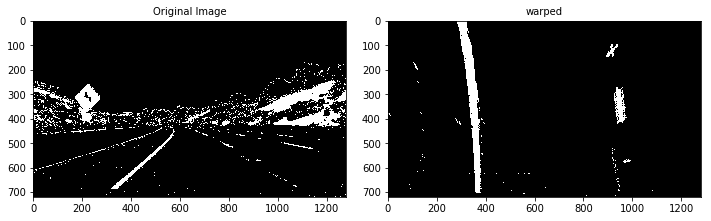

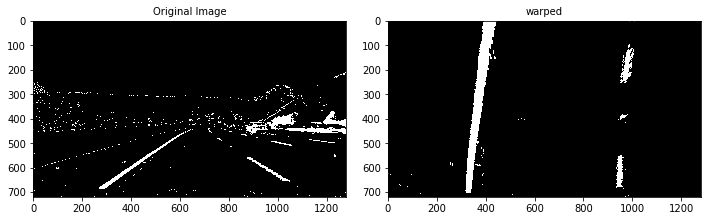

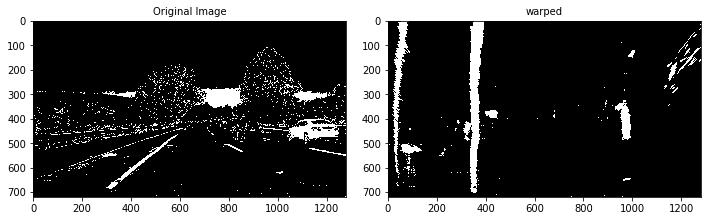

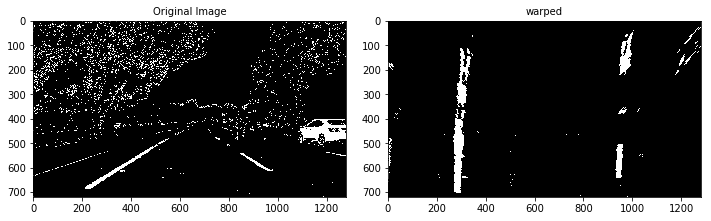

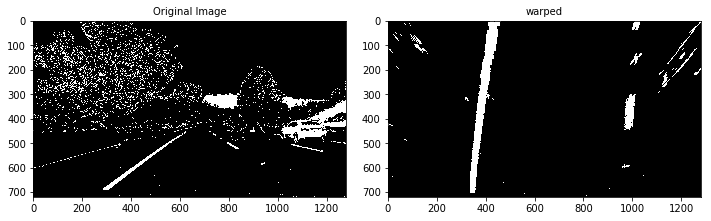

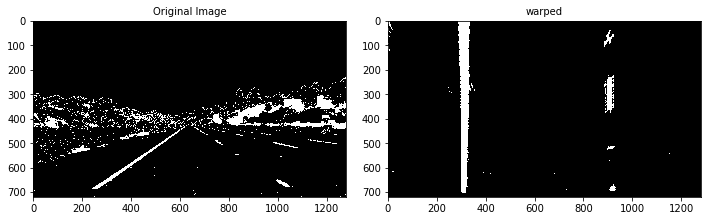

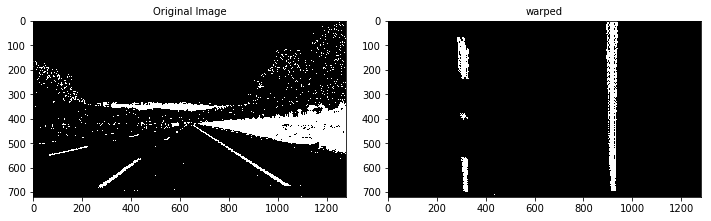

In [21]:
perspectiveImage=[]
for img in binaryImage:
    warped = perspectiveTransform(img)
    perspectiveImage.append(warped[0])
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()
    ax1.imshow(img,cmap='gray')
    ax1.set_title('Original Image', fontsize=10)
    
    ax2.imshow(warped[0],cmap='gray')
    ax2.set_title('warped', fontsize=10)
    
    
    
    

## IDENTIFY LANE LINE PIXEL

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Inorder to find the lane line pixel i have use the code more or less similar to that of the one used in classroom .
I have done it in three steps:
1) Plotted Histogram to get the peak values
2) Performed Sliding window search
3) Searching around previously detected lane

#### Histogram

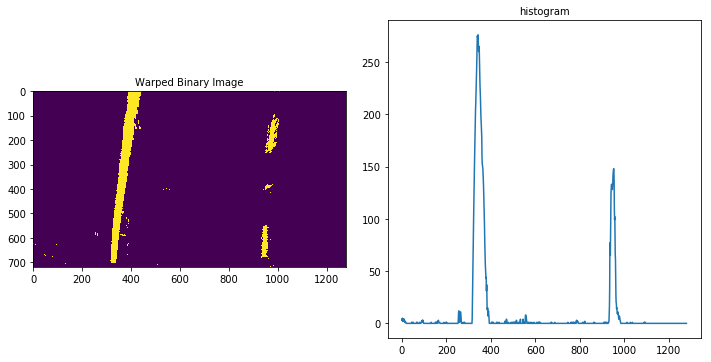

In [28]:
def get_histogram(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    return histogram
    


for img in perspectiveImage[2:3]:
    histogram =get_histogram(img)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Warped Binary Image', fontsize=10)
    
    ax2.plot(histogram)
    ax2.set_title('histogram', fontsize=10)
    
    

#### Sliding Window Search

For sliding window search, starting with the base likely positions of the 2 lanes, calculated from the histogram. I have used 9 windows .

The x & y coordinates of non zeros pixels are found, a polynomial is fit for these coordinates and the lane lines are drawn.

In [29]:
left_fit=None
right_fit=None

def getPeakValue(img):
    histogram =get_histogram(img)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base,rightx_base

def getLane(img):
    global left_fit
    global right_fit
    global left_fitx
    global right_fitx
    
    leftx_base,rightx_base=getPeakValue(img)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])  
    # Current positions to be updated for each window
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    nwindows = 9
        # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
       
        # Set minimum number of pixels found to recenter window
    minpix = 50
        
        # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        #print('$$')
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
            
            #print('yl: ',win_y_low,' yh: ',win_y_high,' xll:',win_xleft_low,' xlh:',win_xleft_high,'xrl: ',win_xright_low,'xrh:',win_xright_high)
            
            # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists            
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
        
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    
    return out_img,left_fitx,right_fitx
    
    
    
    
    
    
    
    
    
    

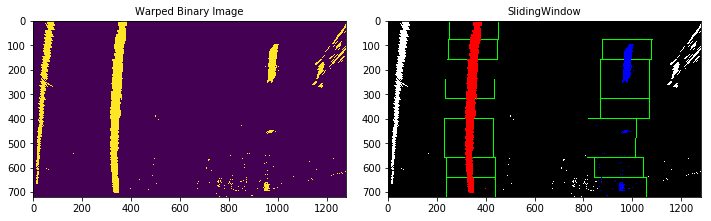

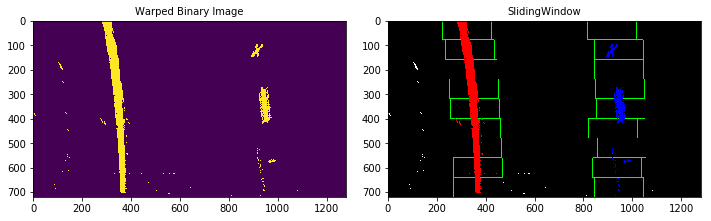

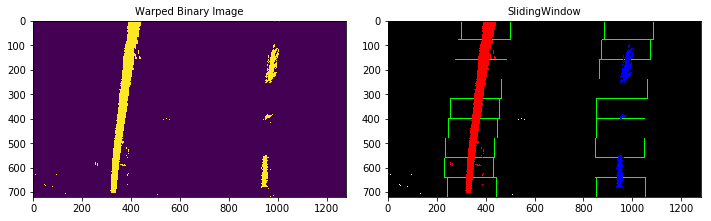

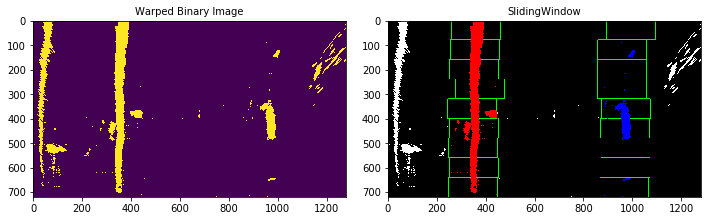

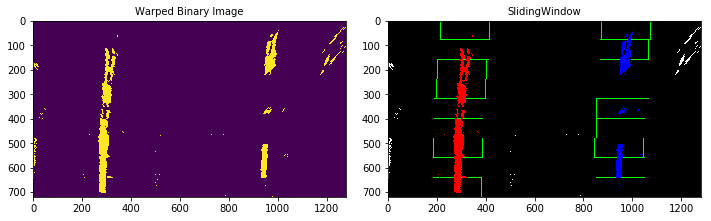

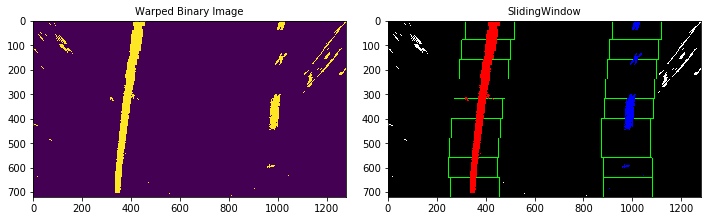

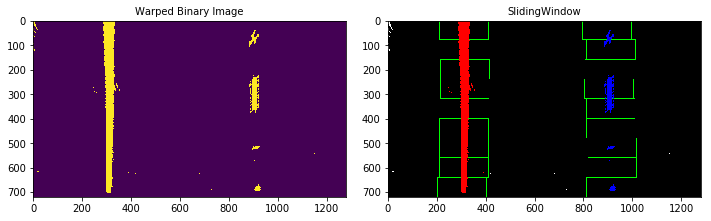

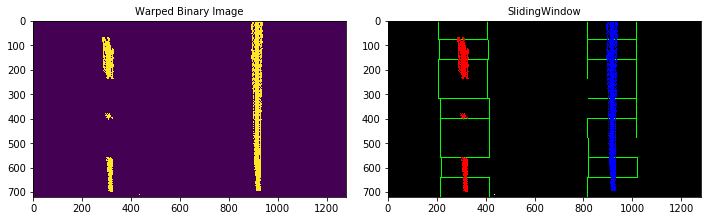

In [30]:
for img in perspectiveImage:
    left_fit=[]
    right_fit=[]
    out_img=getLane(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Warped Binary Image', fontsize=10)
    
    ax2.imshow(out_img[0])
    ax2.set_title('SlidingWindow', fontsize=10)
    

Since consecutive frames are likely to have lane lines in roughly similar positions, in this section we search around a margin of 100 pixels of the previously detected lane lines.

In [31]:
def drawLane(binary_warped):
    global left_fit
    global right_fit
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result,left_fitx,right_fitx
    

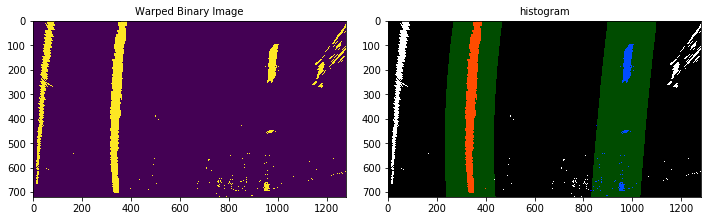

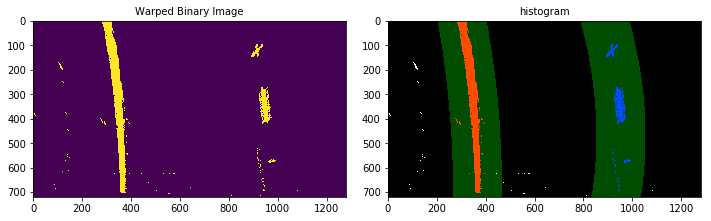

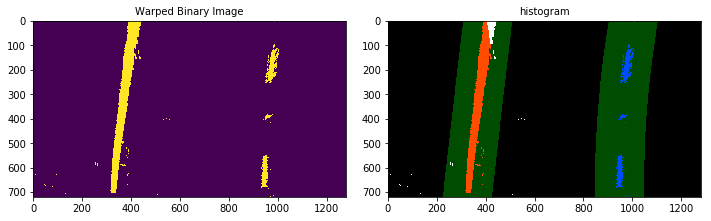

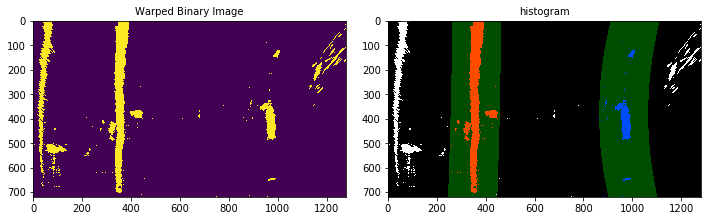

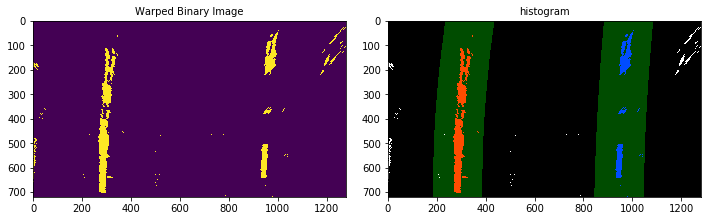

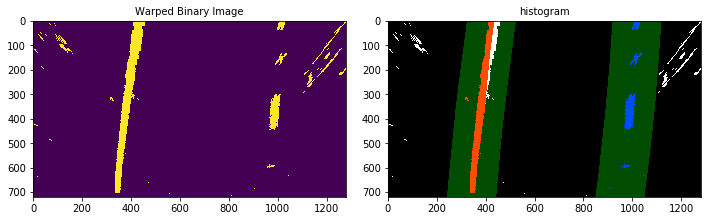

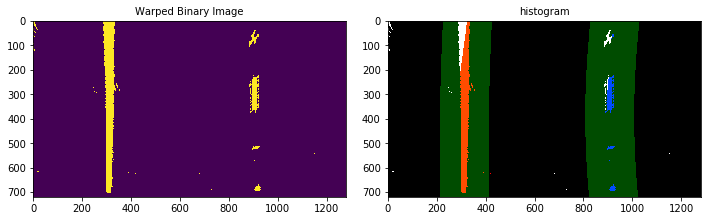

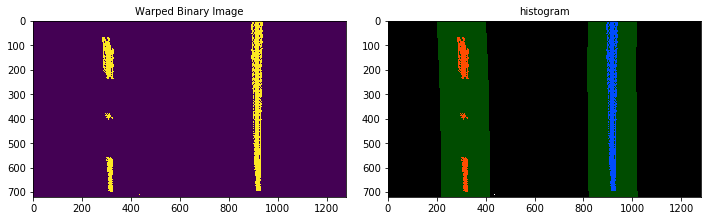

In [32]:
 for img in perspectiveImage:
    out_img=drawLane(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Warped Binary Image', fontsize=10)
    
    ax2.imshow(out_img[0])
    ax2.set_title('histogram', fontsize=10)
    

## RADIUS OF CURVATURE

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

In order to calculate the radius of curvature i used the method as specified in the classroom . I created a function `calc_roc` it excepts two argument first excepts the polynomial of the curve and the other excepts the ploty values.
It returns the curvature of the lane whoes polynomial is passed .

So i calculated the curvature of both the left and right lane individually and tooked average of it . 
This gave me the required center of curvature .


To calculate the vehicle position i tooked the lastValue from the polynomials of each lane and tooked the average of it. This gave me the center of the lane . which i compared with the center of the image on x-axis and got the position of the vehicle.

I have done this in `fillLane ` function

In [33]:
def calc_roc(fit_value,ploty):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, fit_value*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step using the `fillLane function` it excepts the undistorted image , warpedImaged , Minv and a counter value.
`Undistorted image` :is the image on which we will map our resultant image and return it to the pipeline
`WarpedImage`: the perspective transformed of the binary image . We will be using this image to draw lane line and fill the line
`Minv`: is used to unwrap the image and finally merge it with the original undistorted image
`counter` : It will determine when to perform the sliding window search or when to skip it . For this project for every 3rd fram the window will perform the sliding window search

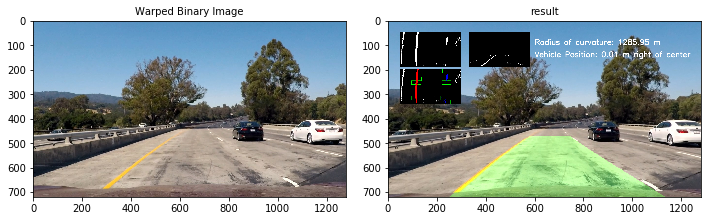

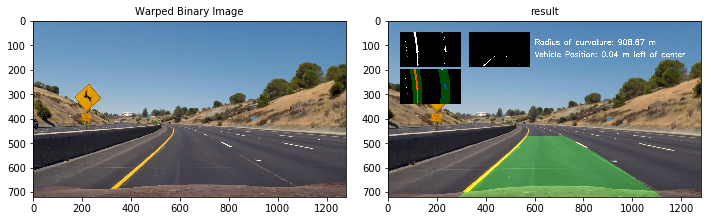

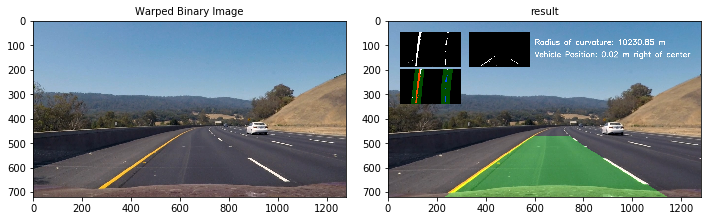

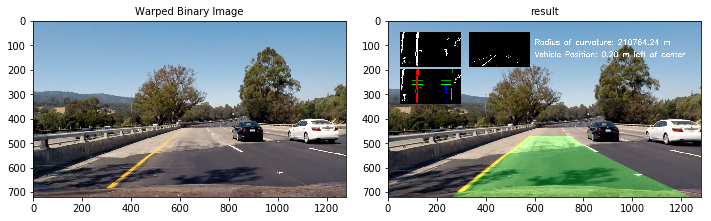

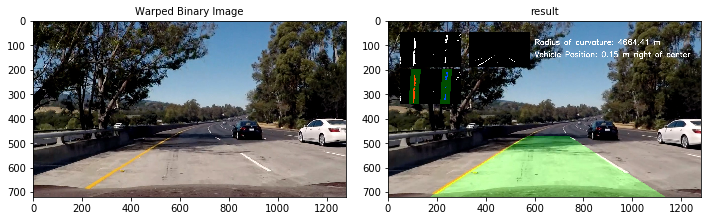

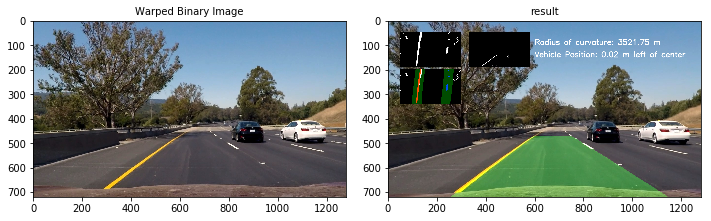

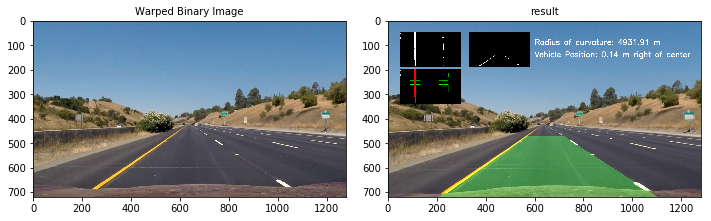

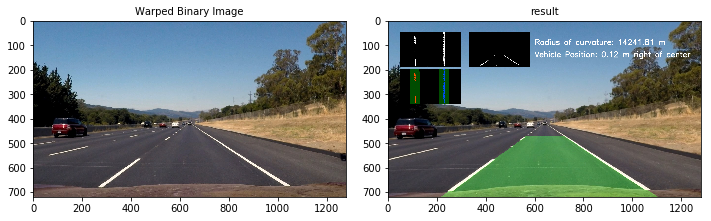

In [34]:
image = glob.glob('test_images/test*.jpg')


def fillLane(undist,warped,Minv,counter):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    if(counter%3==0):
        image,left_fitx,right_fitx=getLane(warped)
    else:
        image,left_fitx,right_fitx=drawLane(warped)
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )  
    # Recast the x and y points into usable format for cv2.fillPoly()
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    left_roc=calc_roc(left_fitx,ploty)
    right_roc=calc_roc(right_fitx,ploty)
    average=(left_roc+right_roc)/2
    
    lane_center = (left_fitx[warped.shape[0]-1] + right_fitx[warped.shape[0]-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_pixel = result.shape[1]/2 - lane_center
    
    
    
    
    center_mtrs = xm_per_pix*center_pixel
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    if(center_pixel>0):
        cv2.putText(result,"Vehicle Position: %.2f m right of center" % abs(center_mtrs),(600,150), font, 1,(255,255,255),2,cv2.LINE_AA)
    elif(center_pixel<0):
        cv2.putText(result,"Vehicle Position: %.2f m left of center" % abs(center_mtrs),(600,150), font, 1,(255,255,255),2,cv2.LINE_AA)
        
    cv2.putText(result,'Radius of curvature: %.2f m'% average,(600,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    
    orignalUnwrapedImage = cv2.warpPerspective(warped, Minv, (image.shape[1], image.shape[0])) 
    orignalUnwrapedImage = cv2.resize(np.dstack((orignalUnwrapedImage,orignalUnwrapedImage,orignalUnwrapedImage))*255, (250,140)) 
    orignalUnwrapedImage=cv2.resize(orignalUnwrapedImage, (250,140))
    
    
    resized_warped = cv2.resize(np.dstack((warped,warped,warped))*255, (250,140)) 
    resized_image=cv2.resize(image, (250,140))
    
    
    
    
    y_offset = 50
    x_offset = 50
    
    result[y_offset:resized_warped.shape[0]+y_offset,x_offset:resized_warped.shape[1]+x_offset]=resized_warped
    result[y_offset:orignalUnwrapedImage.shape[0]+y_offset,330:orignalUnwrapedImage.shape[1]+330]=orignalUnwrapedImage
    result[y_offset+150:resized_warped.shape[0]+y_offset+150,x_offset:resized_warped.shape[1]+x_offset]=resized_image
    
    
    
    return result
counter = 0  
for img in image:
    img=cv2.imread(img)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist=undistort(img)
    combineThreshold=get_thresholded_image(undist)
    #combineThreshold = colorThreshold(undist)
    warped,M,Minv = perspectiveTransform(combineThreshold)
    result = fillLane(undist,warped,Minv,counter)
    counter=counter+1
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Warped Binary Image', fontsize=10)
    
    ax2.imshow(result)
    ax2.set_title('result', fontsize=10)
    
    
    
    

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).


In [35]:
count = 0
def process_image(img):
    global count
    undist=undistort(img)
    combineThreshold=get_thresholded_image(undist)
    #combineThreshold = colorThreshold(undist)
    warped,M,Minv = perspectiveTransform(combineThreshold)
    result = fillLane(undist,warped,Minv,count)
    count=count+1
    return result

In [37]:
output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:52<00:00,  4.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 4min 54s


In [39]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

###  Issues and Challenges

##### Gradient & Color Thresholding

I had to experiment a lot on the threshold values to detect the lane lines . I started with using the s_channel of HLS color space and the sobel_x gradient as suggested in the classroom . But was unable to detect the lane properly . So i explored more on different color channel of different color spaces like LAB,HLS,HSV etc. used there color channel tried the combination and finally was able to figure out to detect the lane using LAB and RGB color channel. The used the gradient along x axis and direction to properly determine the lanes.

##### Perspective transform

I wanted to figure out a way to get the values of src and dst points dynamically but was unable to figure out one. So for the sake of this project I hardcoded the value . 

### Points of failure & Areas of Improvement

1. The challenge video has a section where the car goes underneath a tunnel and no lanes are detected.

To tackle this i am planning to use a technique in which i can lighten the shadow that to by histogram equillization or by some other techniques by going through the reasearch papers. As i have came across few blogs which talks about shadow removal from the image . Because this can even help in harder challenge video
